# Calibrating volatility smiles with SABR
The SABR model, built in 2002, stands as a key stochastic volatility framework in finance for modeling derivatives. SABR stands for "stochastic alpha, beta, rho" which are the key inputs to the model.

SABR is good at capturing the market-observed anomalies such as skew and smile.

It operates on the premise that asset prices follow a geometric Brownian motion while volatility follows an Ornstein-Uhlenbeck process, parameterized by alpha (initial volatility level), beta (variance elasticity), rho (price-volatility correlation), and nu (volatility's volatility).

One of its standout features is the closed-form approximation for implied volatility—known as the Hagan formula—which allows for fast and accurate computations of implied volatility across strike prices.

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from openbb_terminal.sdk import openbb
from pysabr import Hagan2002LognormalSABR
from pysabr import hagan_2002_lognormal_sabr as sabr
from pysabr.black import lognormal_call

Forecasting Toolkit is disabled. To use the Forecasting features please install the toolkit following the instructions here: https://my.openbb.co/app/sdk/installation

Portfolio Optimization Toolkit is disabled. To use the Optimization features please install the toolkit following the instructions here: https://my.openbb.co/app/sdk/installation

In [2]:
symbol = "SPY"
expiration = "2026-01-16"
spy = openbb.stocks.options.chains(symbol, source="YahooFinance")

Output()

In [3]:
calls = spy[spy.optionType == "call"]
jan_2026_c = calls[calls.expiration == expiration].set_index("strike")
jan_2026_c["mid"] = (jan_2026_c.ask + jan_2026_c.ask) / 2

puts = spy[spy.optionType == "put"]
jan_2026_p = puts[puts.expiration == expiration].set_index("strike")
jan_2026_p["mid"] = (jan_2026_p.ask + jan_2026_p.ask) / 2

strikes = jan_2026_c.index
vols = jan_2026_c.impliedVolatility * 100

In [4]:
# Fit the SABR model
f = (
    (jan_2026_c.mid - jan_2026_p.mid)
    .dropna()
    .abs()
    .sort_values()
    .index[0]
)
t = (pd.Timestamp(expiration) - pd.Timestamp.now()).days / 365
beta = 0.5

Put-call parity defines the relationship between put options, call options, and the forward price of the underlying. The t parameter is the fraction of time until expiration.

The beta parameter governs the shape of the forward rate, which influences the shape of the implied volatility smile. A beta of 1 implies a lognormal distribution, which is consistent with the Black-Scholes model. Moving beta away from 1 allows for different shapes of volatility smiles. In practice, setting beta to 0.5 is usually a safe bet.

Once we set the parameters, we instantiate the model and call fit to get alpha, rho, and volvol.

In [5]:

sabr_lognormal = Hagan2002LognormalSABR(
    f=f,
    t=t,
    beta=beta
)

alpha, rho, volvol = sabr_lognormal.fit(strikes, vols)

## Generate a fitted volatility smile

Now that we have alpha, rho, and volvol, we can generate the calibrated volatility smile.

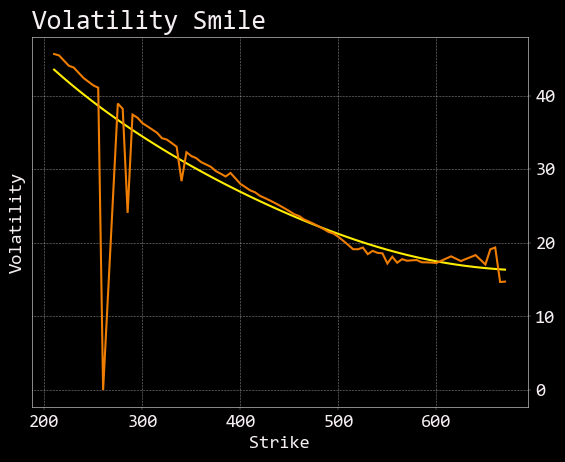

In [6]:

calibrated_vols = [
    sabr.lognormal_vol(strike, f, t, alpha, beta, rho, volvol) * 100
    for strike in strikes
]
plt.plot(
    strikes, 
    calibrated_vols
)

plt.xlabel("Strike")
plt.ylabel("Volatility")
plt.title("Volatility Smile")
plt.plot(strikes, vols)
plt.show()

<Axes: xlabel='strike'>

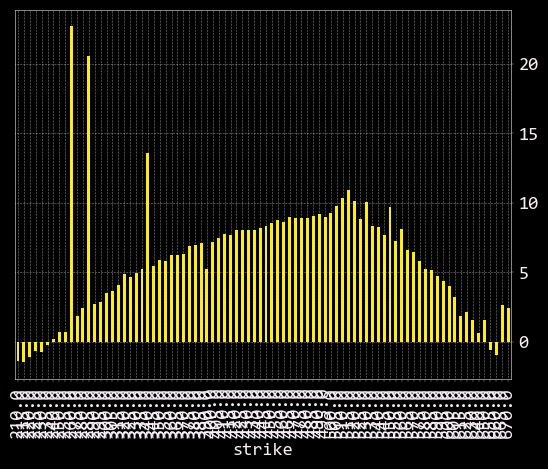

In [7]:
# We can assess the model error as well.
black_values = []
for strike, calibrated_vol in zip(strikes.tolist(), calibrated_vols):
    black_value = lognormal_call(
        strike, 
        f, 
        t, 
        calibrated_vol / 100, 
        0.05, 
        cp="call"
    )
    black_values.append(black_value)


option_values = pd.DataFrame(
    {
        "black": black_values,
        "market": jan_2026_c.mid
    },
    index=strikes
)


(option_values.black - option_values.market).plot.bar()